In [ ]:
import numpy as np
import cupy as cp
import time
from scipy import ndimage
import matplotlib.pyplot as plt
import skimage.io
from cupyx.scipy.ndimage import convolve
import skimage
import cv2
from scipy.ndimage import convolve as convolveNumpy

In [ ]:
# Load and prepare image
url = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.1.05"
image = skimage.io.imread(url)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [ ]:
# Function to visualize images
def visualize(imgs, cmap='gray'):
    n = len(imgs)
    if n == 1:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(imgs[0], cmap=cmap)
        ax.axis('off')
    else:
        fig, axes = plt.subplots(1, n, figsize=(15, 15))
        for i, img in enumerate(imgs):
            ax = axes[i]
            ax.imshow(img, cmap=cmap)
            ax.axis('off')
    plt.show()

In [ ]:
# Convert dummy images to CuPy arrays
imgs = [image]
imgs_cp = [cp.array(img) for img in imgs]

Gaussian Smoothing (NumPy): 0.0086 seconds
Sobel Filters (NumPy): 0.0090 seconds
Non-maximum Suppression (NumPy): 0.0094 seconds
Thresholding (NumPy): 0.0011 seconds
Hysteresis (NumPy): 0.1064 seconds
CPU Time: 0.13498711585998535


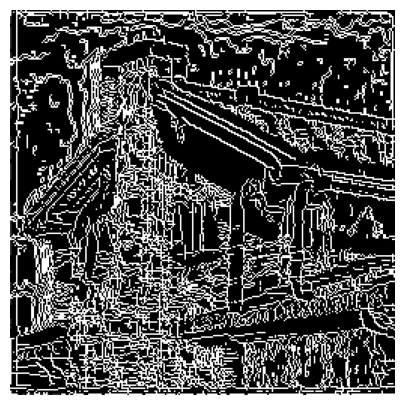

Gaussian Smoothing (CuPy): 0.0023 seconds
Sobel Filters (CuPy): 0.0007 seconds
Non-maximum Suppression (CuPy): 0.0031 seconds
Thresholding (CuPy): 0.0006 seconds
Hysteresis (CuPy): 0.0878 seconds
GPU Time: 0.09576678276062012


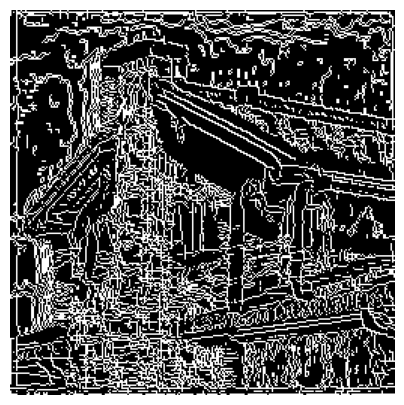

In [49]:
# NumPy-based cannyEdgeDetector
class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold

    def gaussian_kernel(self, size, sigma=1):
        """
        Generate a Gaussian kernel to create a filter for blurring the image.
        Parameters are size of the kernel and sigma.
        """
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        g /= np.sum(g)  # Normalization to sum to 1
        return g.astype(np.float32)

    def gaussian_smooth(self, img):
        """
        Smooth the image using the Gaussian kernel to reduce noise and blur the edges.
        Parameters are the input image to be smoothed and function returns smoothed image.
        """
        kernel = self.gaussian_kernel(self.kernel_size, self.sigma)
        smoothed_image = convolveNumpy(img, kernel, mode='constant')
        return smoothed_image

    def sobel_filters(self, img):
        """
        Apply Sobel filters to compute the gradient magnitude and direction of edges in the image.
        Sobel filters approximate the gradient of the image intensity function.
        """
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.convolve(img, Kx)
        Iy = ndimage.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return G, theta

    def non_max_suppression(self, img, D):
        """
        Perform non-maximum suppression to thin out edges by preserving only local maxima.
        All non-maximum pixels, pixels that are not the maximum in their local neighborhood, are suppresed.
        Parameters are gradient magnitude image(img) and gradient direction image (D).
        """
        angle = D * 180. / np.pi
        angle[angle < 0] += 180

        Z = np.zeros_like(img, dtype=np.int32)

        mask_0 = ((angle >= 0) & (angle < 22.5)) | ((angle >= 157.5) & (angle <= 180))
        mask_45 = (angle >= 22.5) & (angle < 67.5)
        mask_90 = (angle >= 67.5) & (angle < 112.5)
        mask_135 = (angle >= 112.5) & (angle < 157.5)

        q_0 = np.roll(img, -1, axis=1)  # Right
        r_0 = np.roll(img, 1, axis=1)   # Left
        Z = np.where((img >= q_0) & (img >= r_0) & mask_0, img, Z)

        q_45 = np.roll(img, shift=(1, -1), axis=(0, 1))  # Bottom-left
        r_45 = np.roll(img, shift=(-1, 1), axis=(0, 1))  # Top-right
        Z = np.where((img >= q_45) & (img >= r_45) & mask_45, img, Z)

        q_90 = np.roll(img, -1, axis=0)  # Down
        r_90 = np.roll(img, 1, axis=0)   # Up
        Z = np.where((img >= q_90) & (img >= r_90) & mask_90, img, Z)

        q_135 = np.roll(img, shift=(-1, -1), axis=(0, 1))  # Top-left
        r_135 = np.roll(img, shift=(1, 1), axis=(0, 1))    # Bottom-right
        Z = np.where((img >= q_135) & (img >= r_135) & mask_135, img, Z)

        return Z

    def threshold(self, img):
        """
        Apply double thresholding to classify edge pixels into strong, weak, or non-edge pixels based on their intensity values.
        This helps in distinguishing true edges from noise and weak edge candidates.
        Image with pixels classified as strong, weak, or non-edge pixels is returned.
        """
        highThreshold = img.max() * self.highThreshold
        lowThreshold = highThreshold * self.lowThreshold

        res = np.zeros_like(img, dtype=np.int32)

        strong_indices = img >= highThreshold
        weak_indices = (img <= highThreshold) & (img >= lowThreshold)

        res[strong_indices] = self.strong_pixel
        res[weak_indices] = self.weak_pixel

        return res

    def hysteresis(self, img):
        """
        Apply hysteresis thresholding to finalize the edge detection process by connecting weak edges to strong edges.
        This helps in preserving continuous edges while eliminating isolated weak edge pixels.
        """
        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if img[i, j] == weak:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
        return img

    def detect(self):
        """
        Detect edges in the input images using the Canny edge detection algorithm.
        This involves applying Gaussian smoothing, Sobel filtering, non-maximum suppression,
        double thresholding, and hysteresis thresholding.
        """
        """imgs_final = []
        for img in self.imgs:
            start_time = time.time()
            self.img_smoothed = self.gaussian_smooth(img)
            end_time = time.time()
            print(f"Gaussian Smoothing (NumPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            end_time = time.time()
            print(f"Sobel Filters (NumPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            end_time = time.time()
            print(f"Non-maximum Suppression (NumPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            self.thresholdImg = self.threshold(self.nonMaxImg)
            end_time = time.time()
            print(f"Thresholding (NumPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            img_final = self.hysteresis(self.thresholdImg)
            end_time = time.time()
            print(f"Hysteresis (NumPy): {end_time - start_time:.4f} seconds")

            imgs_final.append(img_final)"""
        imgs_final = []
        for img in self.imgs:
            self.img_smoothed = self.gaussian_smooth(img)
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            imgs_final.append(img_final)
        return imgs_final

# CuPy-based cannyEdgeDetector
class cupyCannyEdgeDetector:
    """
    Does the same as cannyEdgeDetector, but using cupy.
    """
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold

    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = cp.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * cp.pi * sigma**2)
        g = cp.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        g /= cp.sum(g)
        return g.astype(cp.float32)

    def gaussian_smooth(self, img):
        kernel = self.gaussian_kernel(self.kernel_size, self.sigma)
        smoothed_image = convolve(img, kernel, mode='constant')
        return smoothed_image

    def sobel_filters(self, img):
        Kx = cp.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], cp.float32)
        Ky = cp.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], cp.float32)

        Ix = convolve(img, Kx)
        Iy = convolve(img, Ky)


        G = cp.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = cp.arctan2(Iy, Ix)
        return G, theta

    def non_max_suppression(self, img, D):
        angle = D * 180. / cp.pi
        angle = cp.where(angle < 0, angle + 180, angle)

        Z = cp.zeros_like(img, dtype=cp.int32)
        mask_0 = ((angle >= 0) & (angle < 22.5)) | ((angle >= 157.5) & (angle <= 180))
        mask_45 = (angle >= 22.5) & (angle < 67.5)
        mask_90 = (angle >= 67.5) & (angle < 112.5)
        mask_135 = (angle >= 112.5) & (angle < 157.5)

        q_0 = cp.roll(img, -1, axis=1)  # Right
        r_0 = cp.roll(img, 1, axis=1)   # Left
        Z = cp.where((img >= q_0) & (img >= r_0) & mask_0, img, Z)

        q_45 = cp.roll(img, shift=(1, -1), axis=(0, 1))  # Bottom-left
        r_45 = cp.roll(img, shift=(-1, 1), axis=(0, 1))  # Top-right
        Z = cp.where((img >= q_45) & (img >= r_45) & mask_45, img, Z)

        q_90 = cp.roll(img, -1, axis=0)  # Down
        r_90 = cp.roll(img, 1, axis=0)   # Up
        Z = cp.where((img >= q_90) & (img >= r_90) & mask_90, img, Z)

        q_135 = cp.roll(img, shift=(-1, -1), axis=(0, 1))  # Top-left
        r_135 = cp.roll(img, shift=(1, 1), axis=(0, 1))    # Bottom-right
        Z = cp.where((img >= q_135) & (img >= r_135) & mask_135, img, Z)

        return Z

    def threshold(self, img):
        highThreshold = img.max() * self.highThreshold
        lowThreshold = highThreshold * self.lowThreshold

        res = cp.zeros_like(img, dtype=cp.int32)

        strong_indices = img >= highThreshold
        weak_indices = (img <= highThreshold) & (img >= lowThreshold)

        res = cp.where(strong_indices, self.strong_pixel, res)
        res = cp.where(weak_indices, self.weak_pixel, res)

        return res


    def hysteresis(self, img):
        weak = self.weak_pixel
        strong = self.strong_pixel
        img_out = img.copy()

        weak_pixels = (img_out == weak)
        strong_pixels = (img_out == strong)

        while True:
            new_strong_pixels = weak_pixels[1:-1, 1:-1] & (
                strong_pixels[:-2, :-2] | strong_pixels[:-2, 1:-1] | strong_pixels[:-2, 2:] |
                strong_pixels[1:-1, :-2] | strong_pixels[1:-1, 2:] |
                strong_pixels[2:, :-2] | strong_pixels[2:, 1:-1] | strong_pixels[2:, 2:]
            )

            if not cp.any(new_strong_pixels):
                break

            img_out[1:-1, 1:-1][new_strong_pixels] = strong

            strong_pixels[1:-1, 1:-1] |= new_strong_pixels
            weak_pixels[1:-1, 1:-1] &= ~new_strong_pixels

        img_out[weak_pixels] = 0

        return img_out

    def detect(self):
        """imgs_final = []
        for img in self.imgs:
            start_time = time.time()
            img_smoothed = self.gaussian_smooth(img)
            end_time = time.time()
            print(f"Gaussian Smoothing (CuPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            gradientMat, thetaMat = self.sobel_filters(img_smoothed)
            end_time = time.time()
            print(f"Sobel Filters (CuPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            nonMaxImg = self.non_max_suppression(gradientMat, thetaMat)
            end_time = time.time()
            print(f"Non-maximum Suppression (CuPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            thresholdImg = self.threshold(nonMaxImg)
            end_time = time.time()
            print(f"Thresholding (CuPy): {end_time - start_time:.4f} seconds")

            start_time = time.time()
            img_final = self.hysteresis(thresholdImg)
            end_time = time.time()
            print(f"Hysteresis (CuPy): {end_time - start_time:.4f} seconds")

            imgs_final.append(img_final)"""
        imgs_final = []
        for img in self.imgs:
            self.img_smoothed = self.gaussian_smooth(img)
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            imgs_final.append(img_final)
        return imgs_final

# Timing comparison
start = time.time()
detector_np = cannyEdgeDetector(imgs, sigma=13, kernel_size=8, lowthreshold=0.45, highthreshold=0.55, weak_pixel=52)
edges_cpu = detector_np.detect()
cpu_time = time.time() - start
print("CPU Time:", cpu_time)

edges_cpu_np = [cp.asnumpy(edge) for edge in edges_cpu]
visualize(edges_cpu_np)

start = time.time()
detector_cp = cupyCannyEdgeDetector(imgs_cp, sigma=13, kernel_size=8, lowthreshold=0.45, highthreshold=0.55, weak_pixel=52)
edges_gpu = detector_cp.detect()
gpu_time = time.time() - start
print("GPU Time:", gpu_time)

edges_gpu_np = [cp.asnumpy(edge) for edge in edges_gpu]
visualize(edges_gpu_np)

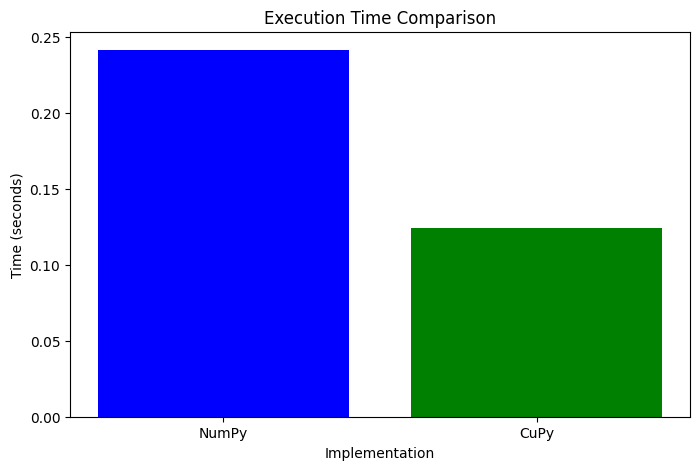

In [30]:
# Execution time comparison
labels = ['NumPy', 'CuPy']
times = [cpu_time, gpu_time]

plt.figure(figsize=(8, 5))
plt.bar(labels, times, color=['blue', 'green'])
plt.title('Execution Time Comparison')
plt.xlabel('Implementation')
plt.ylabel('Time (seconds)')
plt.show()

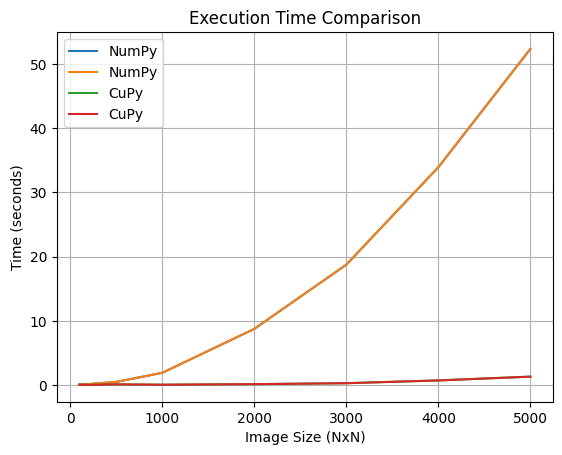

In [46]:
#Time of execution on cpu and gpu depending on image size

sizes = [(100, 100), (200, 200), (500, 500), (1000, 1000), (2000, 2000), (3000, 3000), (4000, 4000), (5000, 5000)]

numpy_times = []
cupy_times = []

for size in sizes:
    resized_image = cv2.resize(image, size[::-1])

    resized_image_cp = cp.array(resized_image)

    start_time = time.time()
    detector_np = cannyEdgeDetector([resized_image], sigma=13, kernel_size=8, lowthreshold=0.45, highthreshold=0.55, weak_pixel=52)
    edges_cpu = detector_np.detect()
    numpy_times.append(time.time() - start_time)

    start_time = time.time()
    detector_cp = cupyCannyEdgeDetector([resized_image_cp], sigma=13, kernel_size=8, lowthreshold=0.45, highthreshold=0.55, weak_pixel=52)
    edges_gpu = detector_cp.detect()
    cupy_times.append(time.time() - start_time)

plt.plot(sizes, numpy_times, label='NumPy')
plt.plot(sizes, cupy_times, label='CuPy')
plt.title('Execution Time Comparison')
plt.xlabel('Image Size (NxN)')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
#All results of parts of the canny detector, implemented with numpy and cupy

# Gaussian Kernel
size = 6
sigma = 10
kernel_np = detector_np.gaussian_kernel(size, sigma)
kernel_cp = detector_cp.gaussian_kernel(size, sigma)
print("Gaussian Kernel (NumPy):\n", kernel_np)
print("Gaussian Kernel (CuPy):\n", kernel_cp)

for img in imgs:
  # Gaussian Smoothing (continued)
  smoothed_image_np = detector_np.gaussian_smooth(img)
  smoothed_image_cp = detector_cp.gaussian_smooth(cp.array(img))
  print("Smoothed Image (NumPy):\n", smoothed_image_np)
  print("Smoothed Image (CuPy):\n", smoothed_image_cp)

# Sobel Filters
gradient_mag_np, gradient_theta_np = detector_np.sobel_filters(smoothed_image_np)
gradient_mag_cp, gradient_theta_cp = detector_cp.sobel_filters(smoothed_image_cp)
print("Gradient Magnitude (NumPy):\n", gradient_mag_np)
print("Gradient Magnitude (CuPy):\n", gradient_mag_cp)
print("Gradient Theta (NumPy):\n", gradient_theta_np)
print("Gradient Theta (CuPy):\n", gradient_theta_cp)

# Non-maximum Suppression
non_max_np = detector_np.non_max_suppression(gradient_mag_np, gradient_theta_np)
non_max_cp = detector_cp.non_max_suppression(gradient_mag_cp, gradient_theta_cp)
print("Non-maximum Suppression (NumPy):\n", non_max_np)
print("Non-maximum Suppression (CuPy):\n", non_max_cp)

# Thresholding
threshold_np = detector_np.threshold(non_max_np)
threshold_cp = detector_cp.threshold(non_max_cp)
print("Thresholding (NumPy):\n", threshold_np)
print("Thresholding (CuPy):\n", threshold_cp)

# Hysteresis
hysteresis_np = detector_np.hysteresis(threshold_np)
hysteresis_cp = detector_cp.hysteresis(threshold_cp)
print("Hysteresis (NumPy):\n", hysteresis_np)
print("Hysteresis (CuPy):\n", hysteresis_cp)

# Gaussian Smoothing
input_image = np.random.rand(100, 100)  # Sample input image

Gaussian Kernel (NumPy):
 [[0.01940704 0.01989833 0.02019905 0.0203003  0.02019905 0.01989833
  0.01940704]
 [0.01989833 0.02040206 0.0207104  0.02081421 0.0207104  0.02040206
  0.01989833]
 [0.02019905 0.0207104  0.02102339 0.02112877 0.02102339 0.0207104
  0.02019905]
 [0.0203003  0.02081421 0.02112877 0.02123468 0.02112877 0.02081421
  0.0203003 ]
 [0.02019905 0.0207104  0.02102339 0.02112877 0.02102339 0.0207104
  0.02019905]
 [0.01989833 0.02040206 0.0207104  0.02081421 0.0207104  0.02040206
  0.01989833]
 [0.01940704 0.01989833 0.02019905 0.0203003  0.02019905 0.01989833
  0.01940704]]
Gaussian Kernel (CuPy):
 [[0.01940704 0.01989833 0.02019905 0.0203003  0.02019905 0.01989833
  0.01940704]
 [0.01989833 0.02040206 0.0207104  0.02081421 0.0207104  0.02040206
  0.01989833]
 [0.02019905 0.0207104  0.02102339 0.02112877 0.02102339 0.0207104
  0.02019905]
 [0.0203003  0.02081421 0.02112877 0.02123468 0.02112877 0.02081421
  0.0203003 ]
 [0.02019905 0.0207104  0.02102339 0.02112877 0.0